In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

TD 3-4

Enoncé : 

------------------------------------------------------------------------------------------------------------------------------------------------------

1/ A partir des données fournies (historique d’une action, colonne B), créez l’historique du portefeuille
de réplication d’un call européen de maturité le 31/12/2018, de strike 6 et de volatilité constante égale
à 20%. Ce portefeuille de réplication a-t-il toujours la valeur de l’option ? Pourquoi ?

2/ On suppose qu’on dispose en plus d’une autre option de mêmes caractéristiques (en particulier une
volatilité de 20%), sinon le strike qui vaut 6.5. On se propose de répliquer notre option initiale en delta
et en gamma. Comment procéder ? Ce nouveau portefeuille de réplication a-t-il toujours la valeur de
l’option ?

3/ Représenter le prix d’un call européen en fonction du paramètre de volatilité et calibrer la volatilité
implicite en utilisant l’algorithme de Newton-Raphson puis l’algorithme de dichotomie.

4/ Estimer l’historique de volatilité implicite pour les deux options dont on a l’historique de prix
(colonnes C et D).

5/ Déterminer rétrospectivement la meilleure couverture dynamique pour la première option (strike
de 6, colonne C), puis proposer un portefeuille de réplication pour la dernière date (pour vous couvrir
jusqu’au lendemain). Vous déposerez votre réponse ici : https://goo.gl/forms/9bobGfSpaU9aRDWF3
(cela contribuera à une partie de la note finale de ce cours, l’absence de réponse fera donc baisser
cette note). Lors de la prochaine séance, le P&L obtenu par votre stratégie de réplication vous sera
dévoilé.


----------------------------------------------------------------------------------------------------------------------------------

On charge les données

In [5]:
data = pd.read_excel("Données TD3.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Prix action,Prix option strike 6,"Prix option strike 6,5"
0,2017-10-02,6.7420,NaN,NaN
1,2017-10-03,6.9550,NaN,NaN
2,2017-10-04,6.9100,1.02096,0.59093
3,2017-10-05,7.0060,1.09932,0.65885
4,2017-10-06,7.0000,1.09306,0.65440
...,...,...,...,...
253,2018-09-28,5.8440,0.28498,0.19737
254,2018-10-01,5.7240,0.24261,0.16974
255,2018-10-02,5.6900,0.24491,0.17452
256,2018-10-03,5.7260,0.27191,0.19592


On plot le prix de l'action

<Figure size 432x288 with 0 Axes>

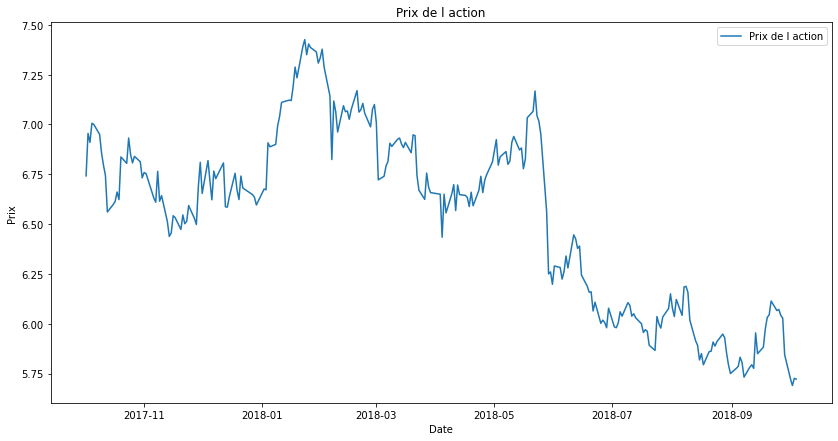

In [15]:
plt.figure()
plt.figure(figsize=(14, 7))
plt.plot(data['Date'].values,data['Prix action'].values, label='Prix de l action')
plt.title('Prix de l action')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()

Première question : 

1/ A partir des données fournies (historique d’une action, colonne B), créez l’historique du portefeuille
de réplication d’un call européen de maturité le 31/12/2018, de strike 6 et de volatilité constante égale
à 20%. Ce portefeuille de réplication a-t-il toujours la valeur de l’option ? Pourquoi ? 

Formule de BlackScholes et paramètre du modèle

In [7]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


strike = 6  
maturity = pd.to_datetime('2018-12-31')  
risk_free_rate = 0.0 
volatility = 0.20  

Calcule du T, temps à maturité

In [8]:
data['TempsTM'] = (maturity - data['Date']).dt.total_seconds() / (365 * 24 * 60 * 60)

Calcul du prix du call en fonction du TTM et prix de l'action

In [9]:
data['Prix Call'] = data.apply(lambda row: black_scholes_call_price(
    S=row['Prix action'],
    K=strike,
    T=row['TempsTM'],
    r=risk_free_rate,
    sigma=volatility), axis=1)

print(data[['Date','TempsTM','Prix action', 'Prix Call']])

          Date   TempsTM  Prix action  Prix Call
0   2017-10-02  1.246575       6.7420   1.012460
1   2017-10-03  1.243836       6.9550   1.173632
2   2017-10-04  1.241096       6.9100   1.138193
3   2017-10-05  1.238356       7.0060   1.212687
4   2017-10-06  1.235616       7.0000   1.207450
..         ...       ...          ...        ...
253 2018-09-28  0.257534       5.8440   0.169706
254 2018-10-01  0.249315       5.7240   0.120900
255 2018-10-02  0.246575       5.6900   0.108709
256 2018-10-03  0.243836       5.7260   0.119268
257 2018-10-04  0.241096       5.7223   0.116873

[258 rows x 4 columns]


Calcul du Delta

In [10]:
def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta


data['Delta1'] = data.apply(lambda row: delta_call(
    S = row['Prix action'],
    K = strike,
    T= row ['TempsTM'],
    r= risk_free_rate,
    sigma= volatility), axis =1)


print(data[['Date','TempsTM','Prix action','Prix Call','Delta1']])

          Date   TempsTM  Prix action  Prix Call    Delta1
0   2017-10-02  1.246575       6.7420   1.012460  0.736896
1   2017-10-03  1.243836       6.9550   1.173632  0.780447
2   2017-10-04  1.241096       6.9100   1.138193  0.771918
3   2017-10-05  1.238356       7.0060   1.212687  0.790382
4   2017-10-06  1.235616       7.0000   1.207450  0.789458
..         ...       ...          ...        ...       ...
253 2018-09-28  0.257534       5.8440   0.169706  0.417298
254 2018-10-01  0.249315       5.7240   0.120900  0.336647
255 2018-10-02  0.246575       5.6900   0.108709  0.314013
256 2018-10-03  0.243836       5.7260   0.119268  0.335814
257 2018-10-04  0.241096       5.7223   0.116873  0.332342

[258 rows x 5 columns]


Calcul du porteufeuille de réplication

In [16]:
cash_position = [black_scholes_call_price(data['Prix action'][0], strike, data['TempsTM'][0], risk_free_rate, volatility) - data['Delta1'][0] * data['Prix action'][0]]
stock_position = [data['Delta1'][0]]
portfolio_value = [cash_position[0] + stock_position[0] * data['Prix action'][0]]

for i in range(1, len(data)):
    stock_price_change = data['Prix action'][i] - data['Prix action'][i-1]
    cash_position.append(cash_position[-1] - data['Delta1'][i-1] * stock_price_change)
    stock_position.append(data['Delta1'][i])
    portfolio_value.append(cash_position[-1] + stock_position[-1] * data['Prix action'][i])

data['Cash Position'] = cash_position
data['Stock Position'] = stock_position
data['Portfolio Value'] = portfolio_value

print(data[['Date', 'Prix action', 'Prix Call', 'Delta1', 'Cash Position', 'Stock Position', 'Portfolio Value']])


          Date  Prix action  Prix Call    Delta1  Cash Position  \
0   2017-10-02       6.7420   1.012460  0.736896      -3.955691   
1   2017-10-03       6.9550   1.173632  0.780447      -4.112650   
2   2017-10-04       6.9100   1.138193  0.771918      -4.077530   
3   2017-10-05       7.0060   1.212687  0.790382      -4.151634   
4   2017-10-06       7.0000   1.207450  0.789458      -4.146892   
..         ...          ...        ...       ...            ...   
253 2018-09-28       5.8440   0.169706  0.417298      -3.066817   
254 2018-10-01       5.7240   0.120900  0.336647      -3.016741   
255 2018-10-02       5.6900   0.108709  0.314013      -3.005295   
256 2018-10-03       5.7260   0.119268  0.335814      -3.016600   
257 2018-10-04       5.7223   0.116873  0.332342      -3.015357   

     Stock Position  Portfolio Value  
0          0.736896         1.012460  
1          0.780447         1.315357  
2          0.771918         1.256421  
3          0.790382         1.385782  


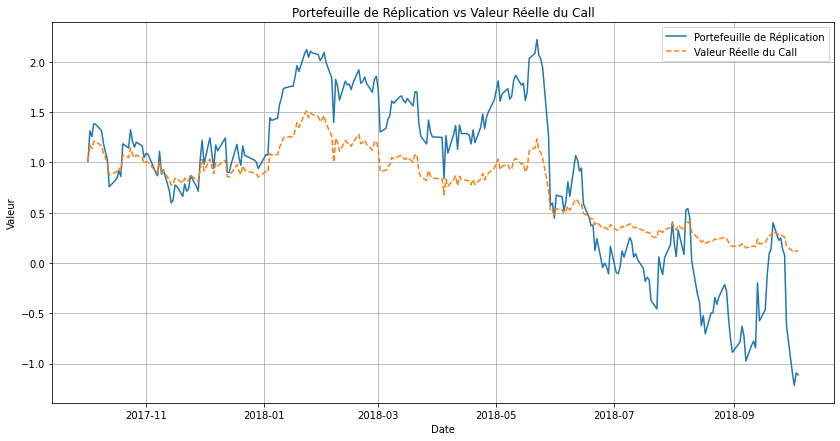

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'].values, data['Portfolio Value'].values, label='Portefeuille de Réplication')
plt.plot(data['Date'].values, data['Prix Call'].values, label='Valeur Réelle du Call', linestyle='--')
plt.title('Portefeuille de Réplication vs Valeur Réelle du Call')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

On voit ici que les variations sont quasi les meme mais avec une amplitude différente donc une différence sur la volatilité pour pouvoir couvrir la réplication

------------------------------------------------------------------------------------------------------------------------------------------------------------

2/ On suppose qu’on dispose en plus d’une autre option de mêmes caractéristiques (en particulier une
volatilité de 20%), sinon le strike qui vaut 6.5. On se propose de répliquer notre option initiale en delta
et en gamma. Comment procéder ? Ce nouveau portefeuille de réplication a-t-il toujours la valeur de
l’option ?

------------------------------------------------------------------------------------------------------------------------------------------------------------

Calcul du Gamma

In [19]:
strike2 = 6.5

In [20]:
def gamma_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

data['Gamma'] = data.apply(lambda row: gamma_call(
    S=row['Prix action'],
    K=strike2,
    T=row['TempsTM'],
    r=risk_free_rate,
    sigma=volatility), axis=1)

data

,Date,Prix action,Prix option strike 6,"Prix option strike 6,5",TempsTM,Prix Call,Delta1,Cash Position,Stock Position,Portfolio Value,Gamma
0,2017-10-02,6.7420,NaN,NaN,1.246575,1.012460,0.736896,-3.955691,0.736896,1.012460,0.255134
1,2017-10-03,6.9550,NaN,NaN,1.243836,1.173632,0.780447,-4.112650,0.780447,1.315357,0.235955
2,2017-10-04,6.9100,1.02096,0.59093,1.241096,1.138193,0.771918,-4.077530,0.771918,1.256421,0.240523
3,2017-10-05,7.0060,1.09932,0.65885,1.238356,1.212687,0.790382,-4.151634,0.790382,1.385782,0.231411
4,2017-10-06,7.0000,1.09306,0.65440,1.235616,1.207450,0.789458,-4.146892,0.789458,1.379314,0.232239
...,...,...,...,...,...,...,...,...,...,...,...
253,2018-09-28,5.8440,0.28498,0.19737,0.257534,0.169706,0.417298,-3.066817,0.417298,-0.628125,0.408992
254,2018-10-01,5.7240,0.24261,0.16974,0.249315,0.120900,0.336647,-3.016741,0.336647,-1.089773,0.330316
255,2018-10-02,5.6900,0.24491,0.17452,0.246575,0.108709,0.314013,-3.005295,0.314013,-1.218561,0.307024
256,2018-10-03,5.7260,0.27191,0.19592,0.243836,0.119268,0.335814,-3.016600,0.335814,-1.093728,0.329310


3/ Représenter le prix d’un call européen en fonction du paramètre de volatilité et calibrer la volatilité
implicite en utilisant l’algorithme de Newton-Raphson puis l’algorithme de dichotomie. 


In [21]:
# Paramètres
S0 = 100  # Prix spot de l'actif sous-jacent
K = 100  # Prix d'exercice (Strike Price)
T = 1    # Temps jusqu'à l'échéance (en années)
r = 0.05 # Taux d'intérêt sans risque
market_price = 10  # Prix du call observé sur le marché

In [22]:
def norm_pdf(x):
    return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x * x)

def black_scholes_vega(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S0 * np.sqrt(T) * norm_pdf(d1)


def implied_volatility_newton_raphson(S0, K, T, r, market_price, sigma_initial_guess=0.2, max_iterations=100, epsilon=1e-6):
    sigma = sigma_initial_guess
    for i in range(max_iterations):
        price = black_scholes_call_price(S0, K, T, r, sigma)
        vega = black_scholes_vega(S0, K, T, r, sigma)
        
        # Calcul de la nouvelle estimation de la volatilité
        sigma = sigma - (price - market_price) / vega
        

        if abs(price - market_price) < epsilon:
            return sigma
    return sigma  



# Calcul et affichage de la volatilité implicite
vol_implicite = implied_volatility_newton_raphson(S0, K, T, r, market_price)
print(f"La volatilité implicite est {vol_implicite:.6f}")


La volatilité implicite est 0.187972


4/ Estimer l’historique de volatilité implicite pour les deux options dont on a l’historique de prix
(colonnes C et D). 


In [79]:
strike6 = 6
strike65=6.5

In [82]:
data['VolI6'] = data.apply(lambda row: implied_volatility_newton_raphson(
    S0=row['Prix action'],
    K=strike6,
    T=row['TempsTM'],
    r=risk_free_rate,
    market_price=row['Prix option strike 6']), axis=1)

print(data['VolI6'])

0           NaN
1           NaN
2      0.145860
3      0.144789
4      0.144311
         ...   
252    0.297813
253    0.298548
254    0.312172
255    0.328587
256    0.341453
Name: VolI6, Length: 257, dtype: float64


In [85]:
data['VolI65'] = data.apply(lambda row: implied_volatility_newton_raphson(
    S0=row['Prix action'],
    K=strike65,
    T=row['TempsTM'],
    r=risk_free_rate,
    market_price=row['Prix option strike 6,5']), axis=1)

print(data['VolI65'])

0           NaN
1           NaN
2      0.116967
3      0.116565
4      0.116687
         ...   
252    0.361408
253    0.362253
254    0.376124
255    0.393196
256    0.406829
Name: VolI65, Length: 257, dtype: float64


5/ Déterminer rétrospectivement la meilleure couverture dynamique pour la première option (strike
de 6, colonne C), puis proposer un portefeuille de réplication pour la dernière date (pour vous couvrir
jusqu’au lendemain).

In [86]:
def derivee_approx(f, x, h=0.0001):
        return (f(x + h) - f(x)) / h